In [1]:
#Plot BKG Files

import csky as cy
import numpy as np
import pandas as pd
import glob
import healpy as hp
import pickle, datetime, socket
import histlite as hl
now = datetime.datetime.now
import matplotlib.pyplot as plt
import click, sys, os, time
import config as cg
import utils
import histlite.heal as heal
from matplotlib import cm
from config import get_seyfert_ps_conf
flush = sys.stdout.flush

Running as User: shiqiyu on Hostname: cobalt06.icecube.wisc.edu


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import histlite as hl
from scipy.interpolate import make_interp_spline, BSpline


import matplotlib
cy.plotting.mrichman_mpl()
colors=['blue', 'green']#, '#ffd343','purple']

In [3]:
font = {'family' : 'normal',
        'size'   : 22}

matplotlib.rc('font', **font)

In [4]:
df_orig = pd.read_hdf('/cvmfs/icecube.opensciencegrid.org/users/shiqiyu/selected_xray_fullsky_seyferts_10yr.h5')
idx = np.logical_and(df_orig['DECdeg'] < -5, df_orig['DECdeg'] > -80)
idx2 = df_orig['neutrino_expectation_estes'] >= 0.155 #10 #top 3

cat = df_orig[idx&idx2].sort_values(by='neutrino_expectation_estes', ascending=False).copy(deep=True)
src_dist = cat['DIST']
src_log_lumin = cat['logL2-10-intr']
flux=cat['F2-10-intr']
decs=cat['DECdeg']
ras=cat['RAdeg']

cutoff_GeV = np.inf * 1e3
weights = flux

In [5]:
circinus = cy.utils.sources(ras[1], decs[1], deg=True)

In [6]:
mask_deg=5
ana_name = 'ESTES'

In [7]:
template_repo, repo, ana_dir, base_dir, job_basedir = cg.template_repo, cg.repo, cg.ana_dir, cg.base_dir, cg.job_basedir

In [8]:
specs = cy.selections.ESTESDataSpecs.ESTES_2011_2021
version = 'version-001-p00'

#ana_name += ' {:+08.3f}'.format(mask_deg)

In [9]:
# define a powerlaw flux (like NGC 1068)
def powerlaw(enu, phi=5e-14, gamma=3.2, ref_energy=1e3):
    '''
    Calculates a powerlaw flux.
    Args
        enu (float): neutrino energy in GeV
        phi (float): flux normalization at ref_energy. units 1/GeV 1/cm^2 1/s
                        default: 5e-14 (like NGC 1068)
        gamma (float): spectral index
                        default: 3.2 (like NGC 1068)
    Returns
        flux (float) in units of 1/GeV 1/cm^2 1/s at given neutrino energy
    '''
    
    return phi * (enu / ref_energy)**(-gamma)

In [10]:
from lib_bass_seyferts import get_nevents_from_source

In [11]:
path_to_mc = './data/estes/version-001-p00/'
mc = np.load(path_to_mc+'MC_All_Combined.npy')

In [12]:
# create powerlaw flux
gamma=3.2
phi=5.4e-14
ltime = 8.7
F210_intr_1068 = 268.3
pflux = lambda enu, gamma=gamma, phi=phi: powerlaw(enu, gamma=gamma, phi=phi)
# calculate event expectation
nev = get_nevents_from_source(mc, decs[1], pflux, ltime=ltime) / F210_intr_1068 * flux[1]
print(f'powerlaw flux at dec {decs[1]:.2f} expect: {nev:.1f} events.')
print('')

powerlaw flux at dec -65.34 expect: 6.4 events.



In [13]:
krag5_map, krag5_energy_bins = cy.selections.mrichman_repo.get_template(
        'KRA-gamma_5PeV_maps_energies', per_pixel_flux=True)
kra_flux = cy.hyp.BinnedFlux(
                bins_energy=krag5_energy_bins,
                flux=krag5_map.sum(axis=0))
min_dec=-80
max_dec=80
krag5_map = cg.set_min_max_dec(krag5_map, min_dec, max_dec)

Reading /data/user/mrichman/data/analyses/templates/KRA-gamma_5PeV_maps_energies.tuple.npy ...


In [15]:
gp_conf = {
            'template': krag5_map,
            'bins_energy': krag5_energy_bins,
            'fitter_args': dict(gamma=2.5),
            'randomize': ['ra'],
            'update_bg': False,
            #'sigmas': smears,
            'sigsub': False,
            #'dir': template_dir,
            'bg_temp':True,
            #'flux':kra_flux,
            'space': 'template',
            'bg_weight_names':['astro_weight', 'atmo_weight', 'muon_weight'],
            'inj_conf':{
                'space': 'template',
                'flux':kra_flux,
                'sig': 'template',
                'bg_weight_names':['astro_weight', 'atmo_weight', 'muon_weight'],
                'randomize'      :['ra', 'dec'],
                'update_bg': False,
                },
            cy.pdf.CustomFluxEnergyPDFRatioModel: dict(
                hkw=dict(bins=(
                       np.linspace(-1, 1, 20),
                       np.linspace(np.log10(500), 8.001, 20)
                       )),
                flux=kra_flux,
                features=['sindec', 'log10energy'],
                normalize_axes=([1])),
            'energy': False,
        }

NameError: name 'template_dir' is not defined

In [47]:
kra_nev = get_nevents_from_source(mc, decs[1], kra_flux, ltime=ltime) / F210_intr_1068 * flux[1]


In [72]:
dec_bins= np.linspace(0,1e-7, 100)#-80,80,160)

In [73]:
kra_flux.to_ns(krag5_map,F210_intr_1068* flux[1])

/home/shiqiyu/csky/csky/hyp.py:187: RuntimeWarning: divide by zero encountered in true_divide
  return acc_total * flux / self.to_E2dNdE(1, 1, E0=E0, unit=unit)
/home/shiqiyu/csky/csky/hyp.py:187: RuntimeWarning: invalid value encountered in true_divide
  return acc_total * flux / self.to_E2dNdE(1, 1, E0=E0, unit=unit)


array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [74]:
fig, ax = plt.subplots (figsize=(20,10))
ax.hist(krag5_map,bins=dec_bins)

([array([1.16446e+05, 3.20720e+04, 1.16790e+04, 7.86700e+03, 5.63700e+03,
         3.56500e+03, 2.66900e+03, 2.06200e+03, 1.72600e+03, 1.44100e+03,
         1.19100e+03, 1.02900e+03, 8.41000e+02, 6.99000e+02, 5.97000e+02,
         5.31000e+02, 4.39000e+02, 4.16000e+02, 3.98000e+02, 3.39000e+02,
         2.66000e+02, 2.28000e+02, 2.53000e+02, 2.10000e+02, 2.10000e+02,
         1.75000e+02, 1.58000e+02, 1.47000e+02, 1.42000e+02, 1.32000e+02,
         1.21000e+02, 1.30000e+02, 7.20000e+01, 1.02000e+02, 8.80000e+01,
         8.00000e+01, 7.20000e+01, 7.70000e+01, 6.80000e+01, 8.50000e+01,
         5.40000e+01, 6.30000e+01, 5.90000e+01, 7.70000e+01, 6.20000e+01,
         5.30000e+01, 5.40000e+01, 3.30000e+01, 4.90000e+01, 4.40000e+01,
         2.80000e+01, 3.30000e+01, 3.70000e+01, 3.60000e+01, 3.00000e+01,
         3.10000e+01, 2.10000e+01, 2.50000e+01, 3.00000e+01, 2.90000e+01,
         3.60000e+01, 3.10000e+01, 1.80000e+01, 2.40000e+01, 2.20000e+01,
         3.10000e+01, 2.10000e+01, 2.0

/cvmfs/icecube.opensciencegrid.org/py3-v4.1.0/RHEL_7_x86_64/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


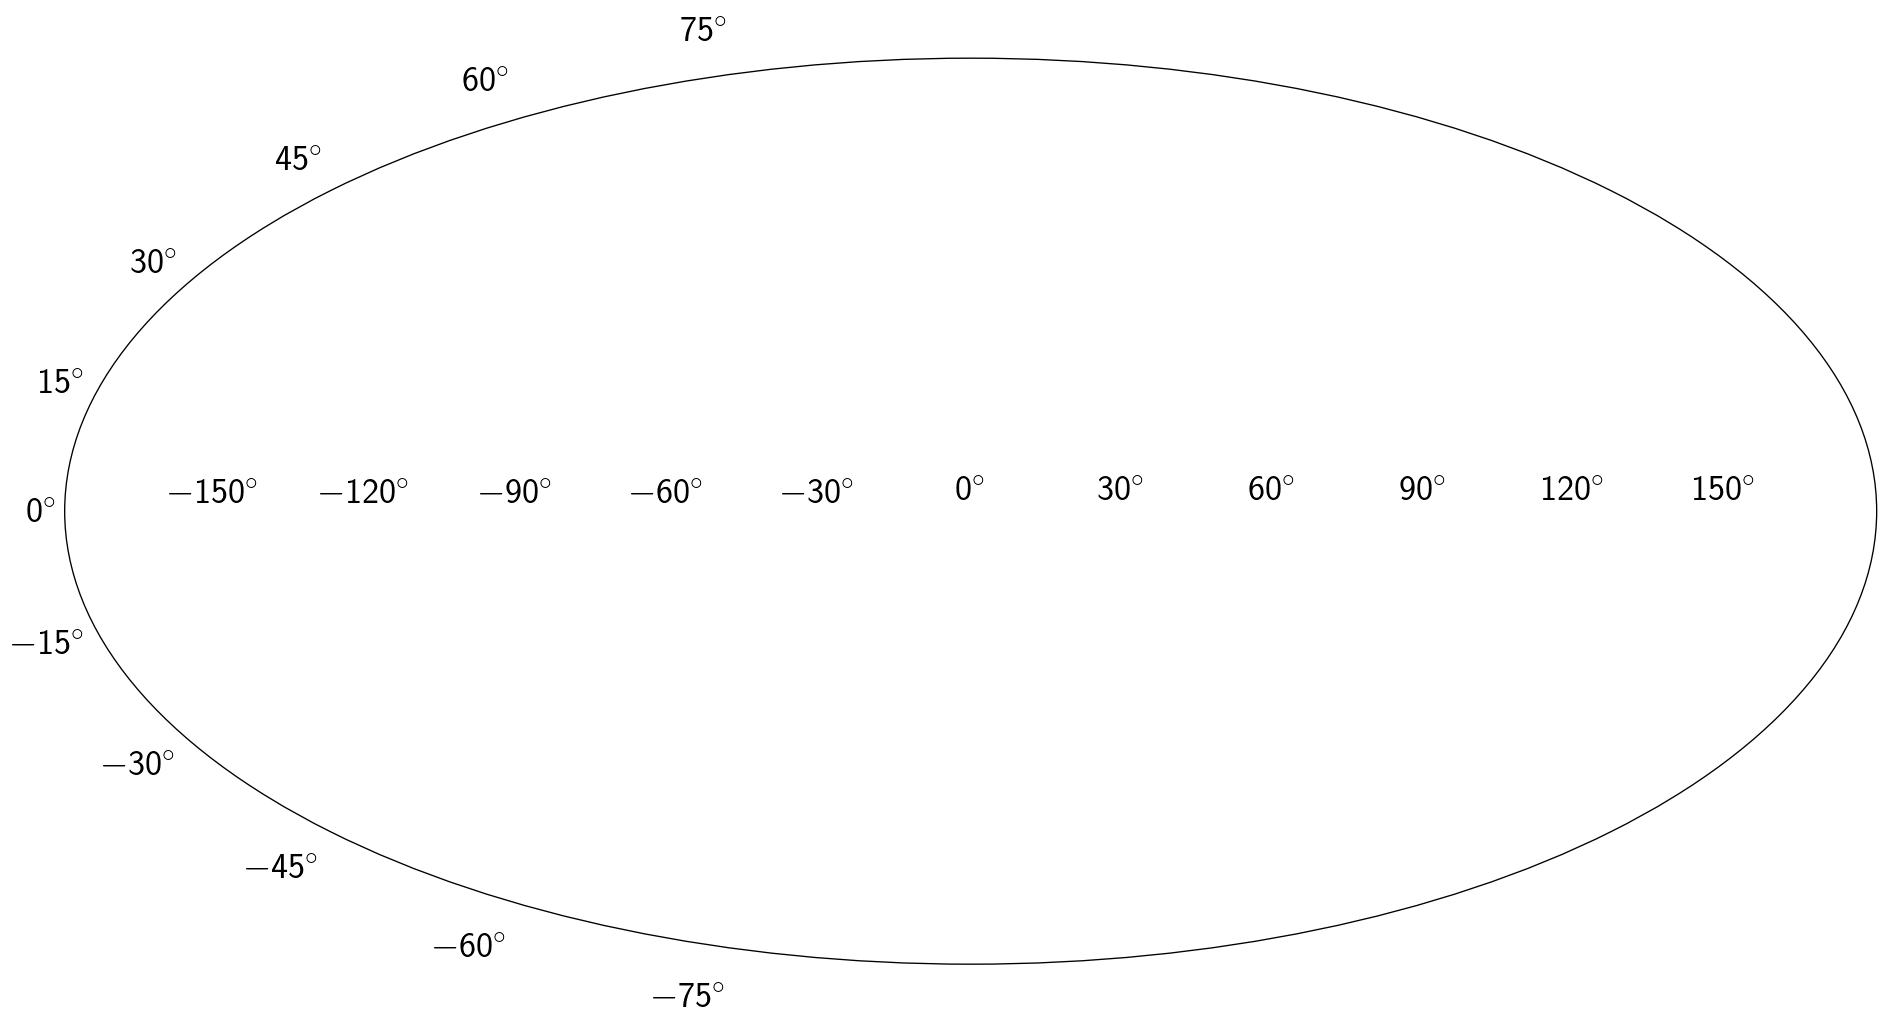

In [51]:
def plot_sky_map_sig(cat, n=30, weighted=False):
    if weighted:
        weights=cat['neutrino_expectation_estes'][0:n]
        vmax=np.max(cat['neutrino_expectation_estes'])
    else:
        weights=None
        vmax=1
    bg_map = heal.hist(50, np.radians(cat['DECdeg'][0:n]), np.radians(cat['RAdeg'][0:n]), weights=weights)

    fig, ax = plt.subplots (figsize=(20,10), subplot_kw=dict (projection='aitoff'))

    cmap=cm.get_cmap('Blues')
    if weighted:
        cmap.set_under('white', 1.0)
        sp = cy.plotting.SkyPlotter(pc_kw=dict(cmap=cmap, vmin=1, vmax =vmax))
    else:
        sp = cy.plotting.SkyPlotter(pc_kw=dict(cmap=cmap, vmin=0, vmax =vmax))
    mesh, cb = sp.plot_map(ax, bg_map.map, n_ticks=2)
    kw = dict(color='.5', alpha=1)#.5)
    sp.plot_gp(ax, lw=.5, **kw)
    sp.plot_gc(ax, **kw)
    cb.set_label ('{} Seyfert Galaxies {}'.format(n, r"(weighted by $\nu_{exp}$)" if weighted else ""))

    ax.grid(**kw)
    plt.tight_layout()
    plt.savefig('plots/masking/sources{}_sky_map{}.png'.format(n, "_weighted" if weighted else ""),bbox_inches='tight')

In [32]:
plot_sky_map_sig(cat)

/cvmfs/icecube.opensciencegrid.org/py3-v4.1.0/RHEL_7_x86_64/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


In [213]:
plot_sky_map_sig(cat, n=3, weighted=True)

In [175]:
src_dec = cat['DECdeg']
src_ra=cat['RAdeg']
src_name = cat['CTPT_NAME']
src_dist = cat['DIST']
src_logl = cat['logL2-10-intr']
src_nus = cat['neutrino_expectation_estes']
src_weight = cat['F2-10-intr']

In [176]:
src = cy.utils.sources(src_ra, src_dec, deg=True)


In [177]:
conf =get_seyfert_ps_conf(src, src_dist, src_logl)


=== Warning: trial runner is using no sigsub!         ===

selected spline: /data/user/shiqiyu/northern_sky_seyferts/generate_splinetables/splinetables/log10_energyflux_at_1Mpc_Lx_42.4.fits for log-xray-luminosity: 42.39
will correct neutrino flux by luminosity ratio: 0.98
selected spline: /data/user/shiqiyu/northern_sky_seyferts/generate_splinetables/splinetables/log10_energyflux_at_1Mpc_Lx_42.6.fits for log-xray-luminosity: 42.63
will correct neutrino flux by luminosity ratio: 1.07
selected spline: /data/user/shiqiyu/northern_sky_seyferts/generate_splinetables/splinetables/log10_energyflux_at_1Mpc_Lx_43.5.fits for log-xray-luminosity: 43.48
will correct neutrino flux by luminosity ratio: 0.95
selected spline: /data/user/shiqiyu/northern_sky_seyferts/generate_splinetables/splinetables/log10_energyflux_at_1Mpc_Lx_44.1.fits for log-xray-luminosity: 44.09
will correct neutrino flux by luminosity ratio: 0.98
selected spline: /data/user/shiqiyu/northern_sky_seyferts/generate_splinetables/

In [188]:
#tr = cy.get_trial_runner(ana =ana, conf = conf,  mp_cpus=2, logging=True)
tr   = cy.get_trial_runner(ana =ana, conf=conf, inj_conf=conf['inj_conf'],
                           mp_cpus=2,
                           src = src,
                           update_bg = False,
                           sigsub = True)

get custom acc_params
from injector, acc_total:  0.8375018963497421
[<csky.inj.DataInjector object at 0x7f909f57fbd0>] [<csky.inj.MCBackgroundInjector object at 0x7f909f57f690>] [<csky.inj.PointSourceInjector object at 0x7f909f57f110>]


In [191]:
def get_plot_from_csky_injector(src_ra=src_ra, src_dec=src_dec, src_name=src_name, src_dist=src_dist, src_logl=src_logl, src_weight=src_weight, ana=ana, Ninj=100000, nsource=30): #4 #0 #20
    src = cy.utils.sources(src_ra, src_dec, deg=True)
    conf =get_seyfert_ps_conf(src, src_dist, src_logl)
    tr = cy.get_trial_runner(ana =ana, inj_conf = conf['inj_conf'], src = src, conf = conf,  mp_cpus=2, logging=True)
    ninjs=tr.sig_n_injs(Ninj)
    #inject as pure signal
    inj_sig=tr.sig_injs[0].inject(ninjs)
    livetime=tr.sig_injs[0].ana.livetime

    ev, nx =inj_sig
    #print(len(ev)) --> 30
    plt.rcParams["text.usetex"] = False
    plt.figure()
    bins=np.logspace(2, 6)#, 100)
    #saving vars for weights
    acc_total=tr.sig_injs[0].acc_total
    #print(len(tr.sig_injs[0].weights)) = 30

    #creat an array of weights for the sampled events

    all_weights = []
    energys = []
    decs = []
    ras = []
    num = 0
    for ind in range(nsource):
        energy=ev[ind]['log10energy']#10**ev[0]['log10energy']
        dec = ev[ind]['dec']
        decs = np.concatenate((decs, dec))
        ra = ev[ind]['ra']
        ras = np.concatenate((ras, ra))
        energys = np.concatenate((energys, energy))
        num=ind
        """
        probs=tr.sig_injs[0].weights[ind]
        prob_ind=tr.sig_injs[0].indices[ind]
        #associate weights weights with event index
        ind_prob_dict=dict(zip(prob_ind,probs))
        evt_id=inj_sig[0][ind]['idx']
        #print(len(probs), len(prob_ind), len(evt_id))
        
        names = ['ind','probs']
        formats = ['i8','f8']
        dtype = dict(names = names, formats=formats)
        array = np.array(list(ind_prob_dict.items()), dtype=dtype)
        
        weights=[array[array['ind']==evt]['probs'] for evt in evt_id]
        weights=np.concatenate( weights, axis=0 )
        all_weights=np.concatenate((all_weights, weights))
        """
#    plt.hist(10**energys,bins=bins, density = True) #weights=all_weights)
    #n,bins,fig=plt.hist(ev[0]['dec'],bins=100)
#    plt.yscale('log')
#    plt.xscale('log')

#    plt.show()
    
    """    
    plt.figure()
    plt.hist(dec_degs, bins=20,weights=all_weights)
    plt.show()
    """    
    
    fig, ax1 = plt.subplots(figsize=(30,30)) 
    for i in range(nsource):
        ax1.scatter(np.degrees(ev[i]['dec']), np.degrees(ev[i]['ra']), marker='o', alpha =0.5, label=src_name[i])
        #ax1.axvline(np.quantile(np.degrees(ev[i]['dec']), [0.1,0.9]))
        
        print("80% is +/- ", (np.quantile(np.degrees(ev[i]['dec']), 0.9)-np.quantile(np.degrees(ev[i]['dec']), 0.1))/2, "; 90% events: ", (np.quantile(np.degrees(ev[i]['dec']), 0.95)-np.quantile(np.degrees(ev[i]['dec']), 0.05))/2)
    ax1.legend(fontsize=30)
    ax1.set_ylim(0,360)
    ax1.set_xlim(-80, 40)
    ax1.set_xlabel("DEC ($\degree$)",fontsize=30)
    ax1.set_ylabel("RA ($\degree$)$",fontsize=30)
    plt.savefig('plots/masking/seyfert_{}_stacking_csky_injctor_signals_ra_dec.png'.format(nsource))
    
    #nx
    sig_map = heal.hist(50, decs, ras)#ev[0:-1]['dec'], ev[0:-1]['ra'])
    fig, ax = plt.subplots (figsize=(20,10), subplot_kw=dict (projection='aitoff'))
    cmap=cm.get_cmap('Greys')
    sp = cy.plotting.SkyPlotter(pc_kw=dict(cmap=cmap))#, vmin=0, vmax =1))

    mesh, cb = sp.plot_map(ax, sig_map.map, n_ticks=2)
    kw = dict(color='.5', alpha=0.5)
    sp.plot_gp(ax, lw=.5, **kw)
    sp.plot_gc(ax, **kw)
    cb.set_label ('Injected {} Seyfert Galaxies'.format(num+1))

    ax.grid(**kw)
    plt.tight_layout()
    plt.savefig('plots/masking/seyfert_{}_sky_map.png'.format(nsource),bbox_inches='tight')
    #return energys, livetime, conf


=== Warning: trial runner is using no sigsub!         ===

selected spline: /data/user/shiqiyu/northern_sky_seyferts/generate_splinetables/splinetables/log10_energyflux_at_1Mpc_Lx_42.4.fits for log-xray-luminosity: 42.39
will correct neutrino flux by luminosity ratio: 0.98
selected spline: /data/user/shiqiyu/northern_sky_seyferts/generate_splinetables/splinetables/log10_energyflux_at_1Mpc_Lx_42.6.fits for log-xray-luminosity: 42.63
will correct neutrino flux by luminosity ratio: 1.07
selected spline: /data/user/shiqiyu/northern_sky_seyferts/generate_splinetables/splinetables/log10_energyflux_at_1Mpc_Lx_43.5.fits for log-xray-luminosity: 43.48
will correct neutrino flux by luminosity ratio: 0.95
selected spline: /data/user/shiqiyu/northern_sky_seyferts/generate_splinetables/splinetables/log10_energyflux_at_1Mpc_Lx_44.1.fits for log-xray-luminosity: 44.09
will correct neutrino flux by luminosity ratio: 0.98
selected spline: /data/user/shiqiyu/northern_sky_seyferts/generate_splinetables/

/cvmfs/icecube.opensciencegrid.org/py3-v4.1.0/RHEL_7_x86_64/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


<Figure size 720x480 with 0 Axes>

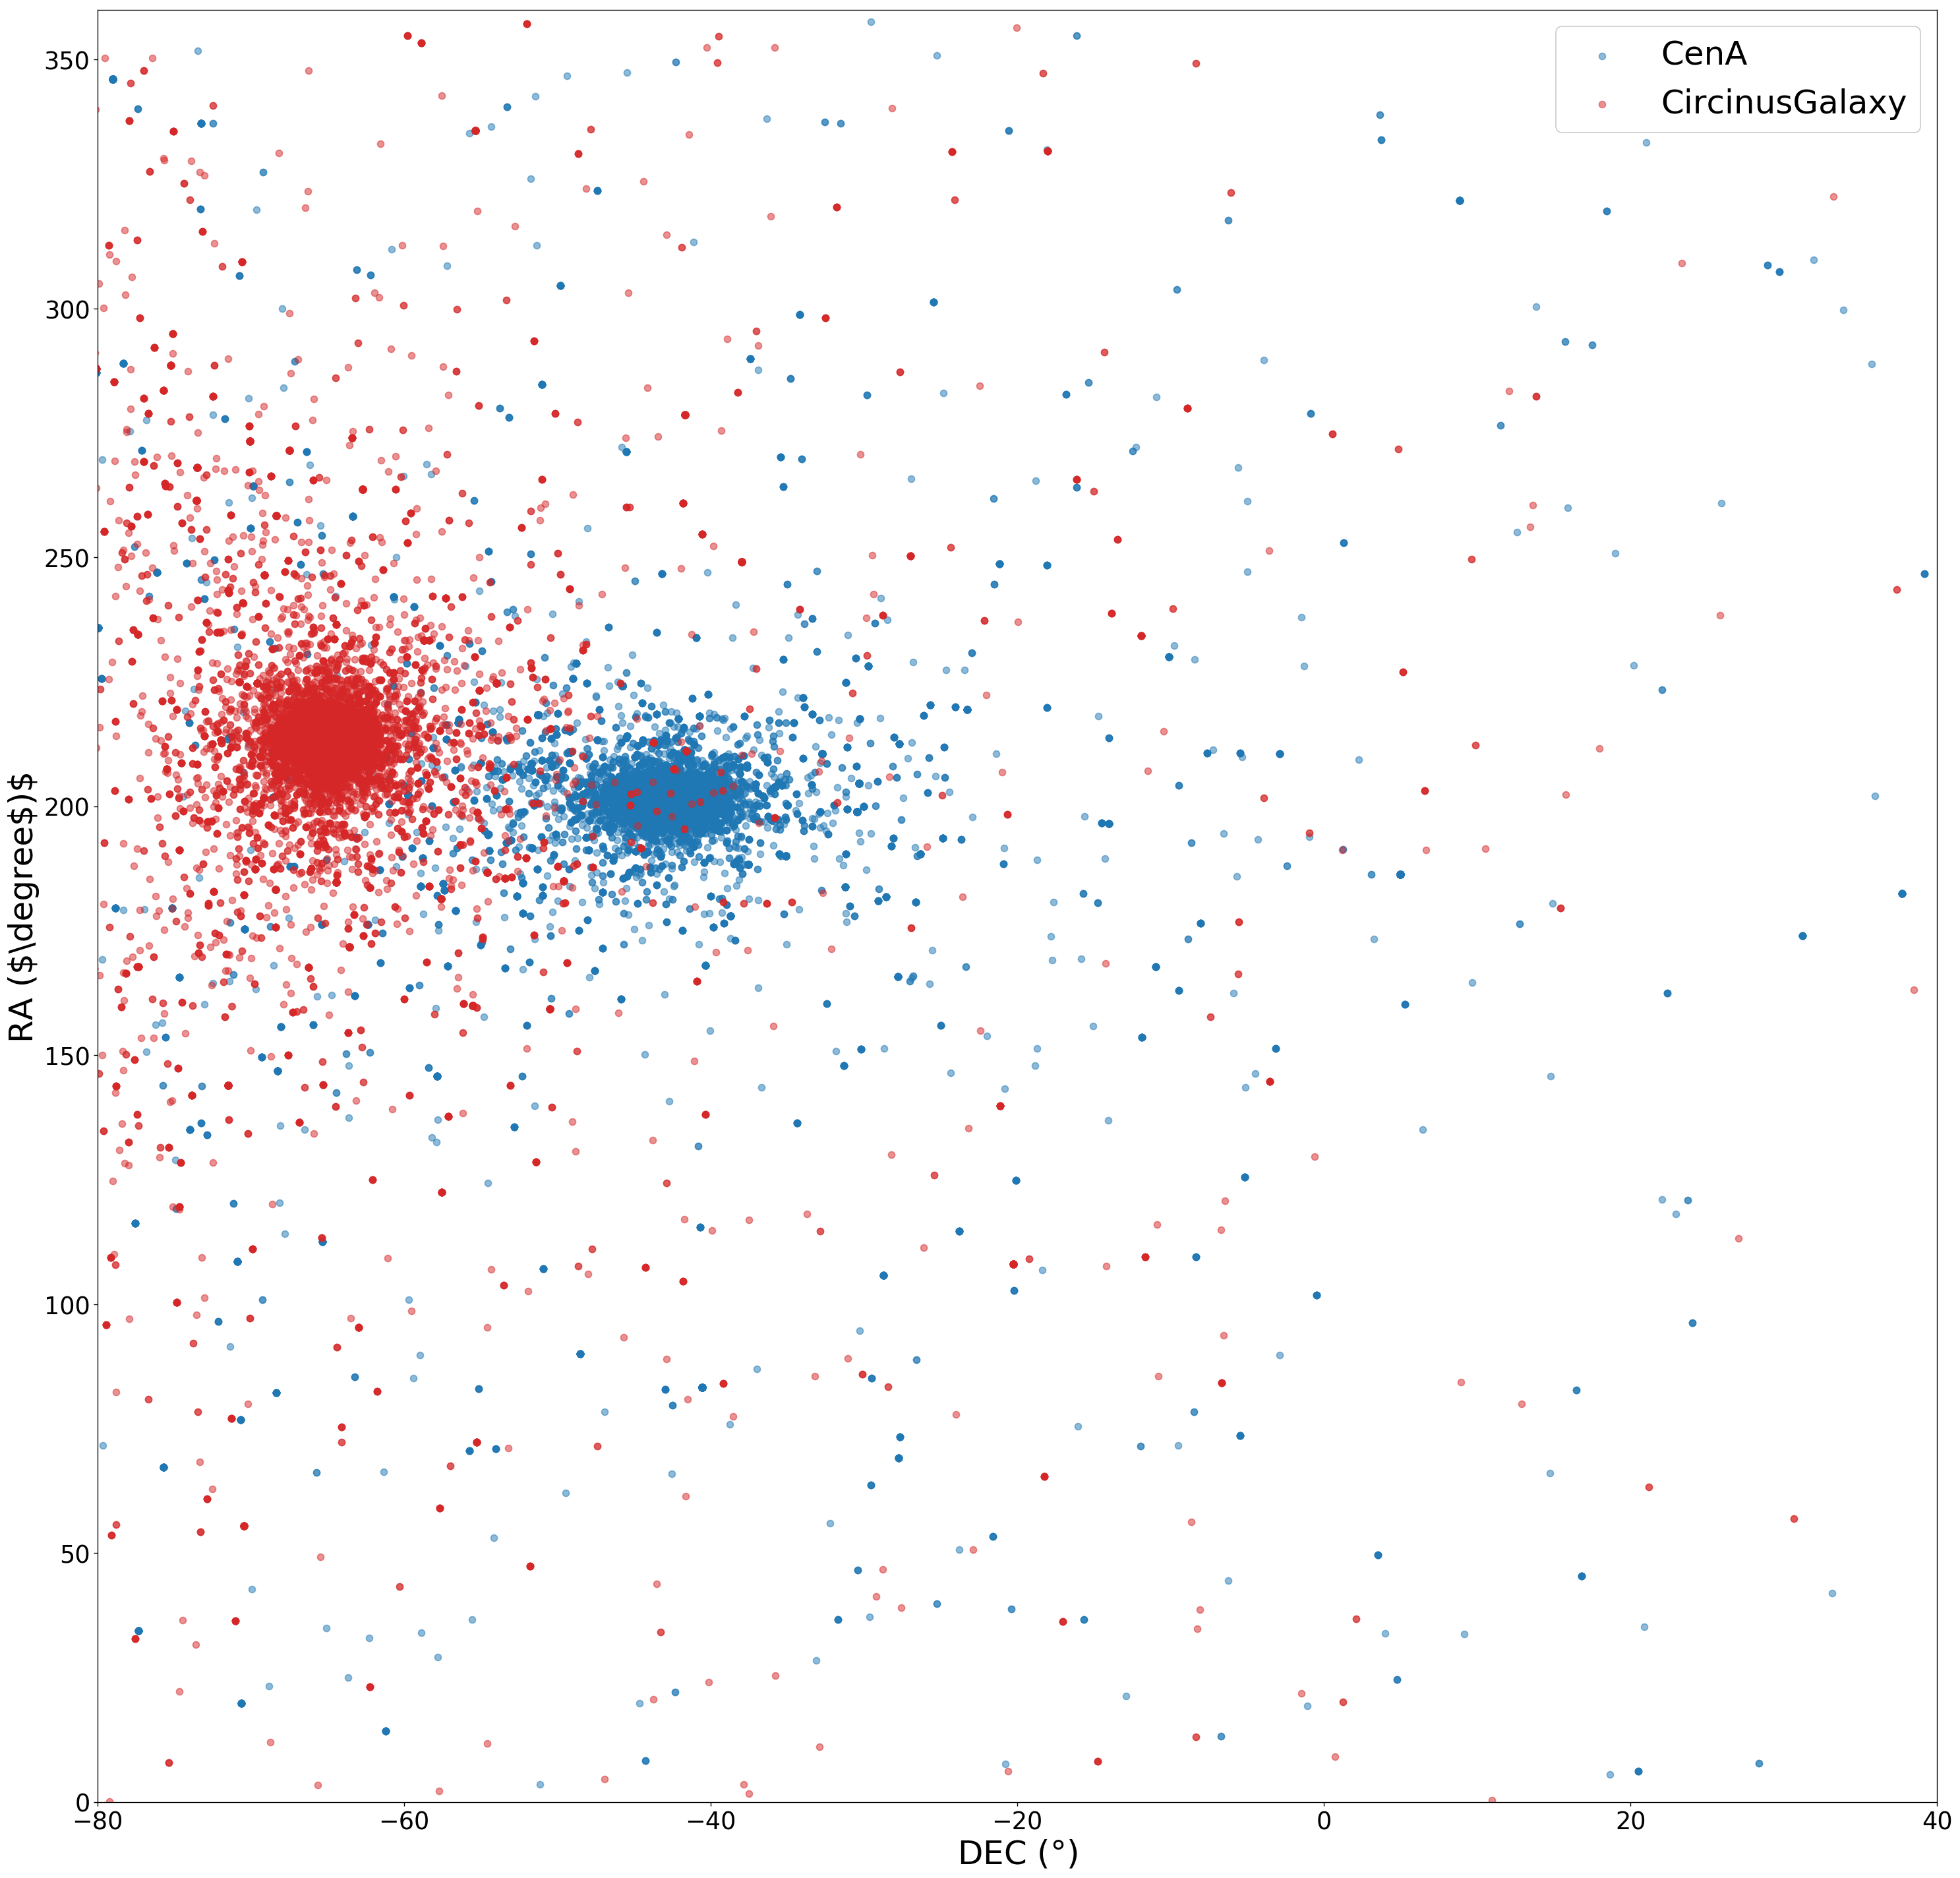

In [192]:
get_plot_from_csky_injector(Ninj=100000, nsource=2)

In [60]:
get_plot_from_csky_injector(Ninj=100000, nsource=4)


=== Warning: trial runner is using no sigsub!         ===

selected spline: /data/user/shiqiyu/northern_sky_seyferts/generate_splinetables/splinetables/log10_energyflux_at_1Mpc_Lx_42.4.fits for log-xray-luminosity: 42.39
will correct neutrino flux by luminosity ratio: 0.98
selected spline: /data/user/shiqiyu/northern_sky_seyferts/generate_splinetables/splinetables/log10_energyflux_at_1Mpc_Lx_42.6.fits for log-xray-luminosity: 42.63
will correct neutrino flux by luminosity ratio: 1.07
selected spline: /data/user/shiqiyu/northern_sky_seyferts/generate_splinetables/splinetables/log10_energyflux_at_1Mpc_Lx_43.5.fits for log-xray-luminosity: 43.48
will correct neutrino flux by luminosity ratio: 0.95
selected spline: /data/user/shiqiyu/northern_sky_seyferts/generate_splinetables/splinetables/log10_energyflux_at_1Mpc_Lx_44.1.fits for log-xray-luminosity: 44.09
will correct neutrino flux by luminosity ratio: 0.98
selected spline: /data/user/shiqiyu/northern_sky_seyferts/generate_splinetables/

/cvmfs/icecube.opensciencegrid.org/py3-v4.1.0/RHEL_7_x86_64/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


<Figure size 720x480 with 0 Axes>

In [189]:
def plot_sky_map_bg(ana,mask_deg):
    a = ana['ESTES_2011_2021']
    bg_data= a.sig_mask
    bg_map = heal.hist(512, bg_data.dec, bg_data.ra)

    fig, ax = plt.subplots (figsize=(10,8), subplot_kw=dict (projection='aitoff'))
    sp = cy.plotting.SkyPlotter(pc_kw=dict(cmap='Blues', vmin=0,vmax=1))
    mesh, cb = sp.plot_map(ax, bg_map.map, n_ticks=2)

    kw = dict(color='.5', alpha=.5)
    sp.plot_gp(ax, lw=.5, **kw)
    sp.plot_gc(ax, **kw)
    cb.set_label ('Events')

    ax.grid(**kw)
    plt.tight_layout()
    plt.savefig('plots/masking/masked_sky_plane_source_{}.png'.format(mask_deg),bbox_inches='tight')

/cvmfs/icecube.opensciencegrid.org/py3-v4.1.0/RHEL_7_x86_64/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


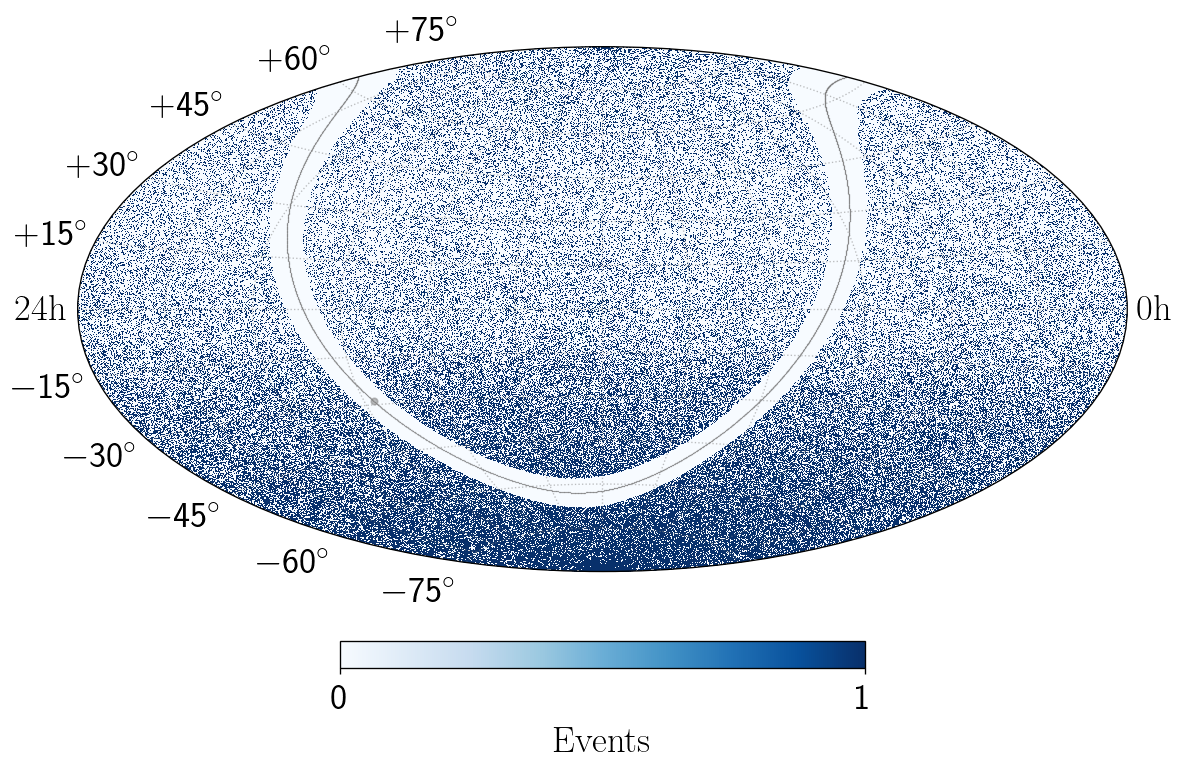

In [190]:
plot_sky_map_bg(ana, mask_deg)

In [ ]:
conf =get_seyfert_ps_conf(src, src_dist, src_logl)

In [193]:
mask_deg=[5, 10, 15, 20]
trs=[]
anas=[]
for mask in mask_deg:
    
    ana = cy.get_analysis(repo, version, specs,
        mask_plane=True, strip=mask,
        space_bg_kw = {'bg_mc_weight':'bg_weight'}, 
        energy_kw = {'bg_mc_weight': 'bg_weight'}, 
        load_sig = True)

    tr = cy.get_trial_runner(ana =ana, inj_conf=conf['inj_conf'], conf = conf, mp_cpus=2, logging=True)
    anas.append(ana)
    trs.append(tr)

Setting up Analysis for:
ESTES_2011_2021
Setting up ESTES_2011_2021...
Energy PDF Ratio Model...
  * gamma = 4.0000 ...
Signal Acceptance Model...
  * gamma = 4.0000 ...
Events(1571852 items | columns: add_weights, astro_weight, atmo_weight, azimuth, bg_weight, dec, energy, event, log10energy, mjd, muon_weight, ra, run, sigma, sindec, subevent, uncorrected_sigma, xdec, xra, true_dec, true_energy, true_ra, oneweight) Events(1571852 items | columns: add_weights, astro_weight, atmo_weight, azimuth, bg_weight, dec, energy, event, log10energy, mjd, muon_weight, ra, run, sigma, sindec, subevent, uncorrected_sigma, xdec, xra, true_dec, true_energy, true_ra, oneweight)
Done.
get custom acc_params
from injector, acc_total:  0.8375018963497421
[<csky.inj.DataInjector object at 0x7f909d92a810>] [<csky.inj.MCBackgroundInjector object at 0x7f909d92a950>] [<csky.inj.PointSourceInjector object at 0x7f909d92a510>]
Setting up Analysis for:
ESTES_2011_2021
Setting up ESTES_2011_2021...
Energy PDF Ratio 

In [217]:
fig, ax1 = plt.subplots(figsize=(10,10)) 
decs=np.linspace(-1,1,20)
colors=['cornflowerblue','blue','lightgreen','forestgreen']
for c, mask, tr in zip(colors, mask_deg, trs):
    inj_bg=tr.bg_injs[0].inject(mask)
    print(len(inj_bg[0][0]['sindec']), np.mean(inj_bg[0][0]['sindec']))
    hist, bin_edges = np.histogram(inj_bg[0][0]['sindec'], bins=decs, density=True)
    #ax1.plot(decs[0:-1], hist, lw=2, label="$\pm$ "+str(mask)+" $\degree$")
    
    #define x as 200 equally spaced values between the min and max of original x 
    xnew = np.linspace(-1,1, 100) 

    #define spline
    spl = make_interp_spline(bin_edges[0:-1], hist, k=3)
    y_smooth = spl(xnew)
    ax1.plot(xnew, y_smooth, lw=2, c=c, label="$\pm$ "+str(mask)+" $\degree$")
    for i in range(5):
        dec=src_dec[i]
        name=src_name[i]
        plt.axvline(np.sin(np.radians(dec)),color='gray', linestyle='dashed', linewidth=2)#, label=name)
        plt.text(x=np.sin(np.radians(dec))-0.01,y=0.1-i*0.01, s=name)
mindec=np.min(np.sin(np.radians(src_dec[0:5])))
maxdec=np.max(np.sin(np.radians(src_dec[0:5])))
ax1.set_xlim(mindec-0.1,maxdec+0.1)#-1,0)
ax1.set_ylim(0,0.1)#mindec-0.1,maxdec+0.1)#-1,0)

plt.legend(fontsize=30)
ax1.set_xlabel("$\sin(\delta)$",fontsize=30)
ax1.set_ylabel("a messed up probability density",fontsize=30)
#plt.savefig("./plots/masking/bg_pdfs_diff_masking_degs_zoomed.png")
plt.savefig("./plots/masking/bg_pdfs_diff_masking_degs.png")

10906 0.1692943833245198
10945 0.17960239191134098
10909 0.17118511216571328
10915 0.17649455288473723


In [195]:
plt.savefig('plots/masking/seyfert_stacking_30_srcs_bg_pdfs_masking.png',bbox_inches='tight')

<Figure size 720x480 with 0 Axes>

In [196]:
def plot_stacking_sig(corona_sig, PL_sig, name1, name2):
    nsigs = [100] #i*50 for i in range(1, 6)]
    tss = corona_sig['ts']
#    tss = np.concatenate(tss,axis=0)
    pl_tss = PL_sig['ts']

#    pl_tss = np.concatenate(pl_tss,axis=0)
    
    title = 'Signal TS'
    fig, ax = plt.subplots(figsize=(18,16))
    PLlabels = ["{} fit, nsig = {}".format(name2, sig) for sig in nsigs]
    labels = ["{} fit, nsig = {}".format(name1, sig) for sig in nsigs]
    bins=np.linspace(0,10,50)
    plt.hist(pl_tss, bins=bins, label=PLlabels, histtype='stepfilled', linewidth=3, alpha=0.5)
    plt.hist(tss, bins=bins,histtype='step', linewidth=3, label=labels)
    plt.plot([],[],'', color='k', label="Model fit")


    plt.axvline(np.median(pl_tss), color='gray', linestyle='dashed', linewidth=3, label='median of {} fit TS'.format(name2))
    plt.axvline(np.median(tss), color='blue', linestyle='dashed', linewidth=3, label='median of {} fit TS'.format(name1))

    ax.set_xlabel(r'TS')
    ax.set_ylabel(r'number of trials')
    ax.set_title(title)
    ax.legend()

    #plt.yscale('log')
    plt.tight_layout()
    #cy.plotting.saving(cy.utils.ensure_dir(plot_dir + '/ps/signal'), 'stacking_signal_TS_'+name1+'_vs_'+name2)
   

In [27]:
# inject GP
specs = cy.selections.DNNCascadeDataSpecs.DNNC_10yr
#ana = cy.get_analysis(repo, 'version-001-p00', specs, dir = base_dir)
ana = cy.get_analysis(repo, 'version-001-p00', specs, dir = ana_dir, mask_plane=True, mask_sources=True, strip=mask_deg, source_r=np.radians(mask_deg), src_tomask=src_mask)
ana_name += ' {:+08.3f}'.format(mask_deg)
#weights[0] = 40

In [31]:
template_repo = cy.selections.Repository(
        local_root='/data/ana/analyses/NuSources/2021_DNNCascade_analyses')

krag5_map, krag5_energy_bins = template_repo.get_template(
    'KRA-gamma_5PeV_maps_energies', per_pixel_flux=True)


Reading /data/ana/analyses/NuSources/2021_DNNCascade_analyses/templates/KRA-gamma_5PeV_maps_energies.tuple.npy ...


In [22]:
def plot_bg_TS(ana1, ana2, name1, name2):

    b1 = cy.dists.Chi2TSD(ana1)
    b2 = cy.dists.Chi2TSD(ana2)
    title = 'BKG TS'

    fig, ax = plt.subplots(figsize=(10,10))
    h1 = b1.get_hist(bins=30)
    h2 = b2.get_hist(bins=30)
    hl.plot1d(ax, h1, crosses=True,
              label='{} bg trials'.format(b1.n_total))
    hl.plot1d(ax, h2, crosses=True,
              label='{} bg trials'.format(b2.n_total))
    x1 = h1.centers[0]
    x2 = h2.centers[0]
    norm1 = h1.integrate().values
    norm2 = h2.integrate().values
    ax.semilogy(x1, norm2 * b1.pdf(x1), lw=2, ls='--',
                label=r'$\chi^2[{:.2f}\sf{{dof}},\ \eta={:.3f}]$'.format(b1.ndof, b1.eta))
    ax.semilogy(x2, norm2 * b2.pdf(x2), lw=2, ls='--',
                label=r'$\chi^2[{:.2f}\sf{{dof}},\ \eta={:.3f}]$'.format(b2.ndof, b2.eta))
    ax.set_xlabel(r'TS')
    ax.set_ylabel(r'number of trials')
    ax.set_title(title)
    ax.axvline(b1.isf_nsigma(5), c='r', ls = '--', label='5$\sigma$ (From Fit)')
    ax.axvline(b1.isf_nsigma(3), c='r', ls = ':', label='3$\sigma$ (From Fit)')
    ax.axvline(b2.isf_nsigma(5), c='r', ls = '--', label='5$\sigma$ (From Fit)')
    ax.axvline(b2.isf_nsigma(3), c='r', ls = ':', label='3$\sigma$ (From Fit)')
    ax.legend()
    plt.tight_layout()

In [23]:
plot_bg_TS(model_inj_PL_weighted_fit_trials, model_inj_model_fit_trials, 'model inj. PL fit', "model inj. & fit")

/cvmfs/icecube.opensciencegrid.org/py3-v4.1.0/RHEL_7_x86_64/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/cvmfs/icecube.opensciencegrid.org/py3-v4.1.0/RHEL_7_x86_64/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/cvmfs/icecube.opensciencegrid.org/py3-v4.1.0/RHEL_7_x86_64/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/cvmfs/icecube.opensciencegrid.org/py3-v4.1.0/RHEL_7_x86_64/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family()

In [ ]:
def plot_sky_map_bg_from_file(trials):
    a = ana['DNNCascade_10yr']
    bg_data, data = a.bg_data, a.data
    bg_map = heal.hist(512, bg_data.dec, bg_data.ra)

    fig, ax = plt.subplots (figsize=(10,8), subplot_kw=dict (projection='aitoff'))
    sp = cy.plotting.SkyPlotter(pc_kw=dict(cmap='Greys', vmin=0,vmax=1))
    mesh, cb = sp.plot_map(ax, bg_map.map, n_ticks=2)

    kw = dict(color='.5', alpha=.5)
    sp.plot_gp(ax, lw=.5, **kw)
    sp.plot_gc(ax, **kw)
    cb.set_label ('Events')

    ax.grid(**kw)
    plt.tight_layout()
    plt.savefig('masking/masked_sky_{}.png'.format(mask_deg),bbox_inches='tight')

In [13]:
n_trials=100
n_sig=100
seed = int (time.time () % 2**32)
gamma=3
cpus=2
def get_gamma_inj_equal_fit_tr(src, gamma, src_dist, src_log_lumin, cpus=2):
    conf = cg.get_ps_conf(src=src, gamma=gamma, cutoff_GeV=cutoff_GeV)
    print(conf)
    tr = cy.get_trial_runner(ana=ana, conf= conf, mp_cpus=cpus)
    return tr
